In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 미래에 볼 영화의 평점 예측하기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import operator

In [3]:
rating_file_path = "/content/drive/MyDrive/이것이데이터분석이다/ch3/ratings.dat.txt"
movie_file_path = "/content/drive/MyDrive/이것이데이터분석이다/ch3/movies.dat.txt"
user_file_path = "/content/drive/MyDrive/이것이데이터분석이다/ch3/users.dat.txt"

rating_data = pd.io.parsers.read_csv(rating_file_path, 
                                     names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::')
movie_data = pd.io.parsers.read_csv(movie_file_path, 
                                    names=['movie_id', 'title', 'genre'], delimiter='::', encoding = 'ISO-8859-1' )
user_data = pd.io.parsers.read_csv(user_file_path, 
                                   names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], delimiter='::')

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


### [데이터셋의 기본정보]

In [4]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
movie_data.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
user_data.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [7]:
print(rating_data.isnull().sum())
print(movie_data.isnull().sum())
print(user_data.isnull().sum())

user_id     0
movie_id    0
rating      0
time        0
dtype: int64
movie_id    0
title       0
genre       0
dtype: int64
user_id       0
gender        0
age           0
occupation    0
zipcode       0
dtype: int64


## 탐색적 데이터 분석
### [분석할 영화의 정보 탐색하기]

In [8]:
# 총 영화의 개수를 출력
print('total number of movie in data :', len(movie_data['movie_id'].unique()))

# 연도별 영화 개수가 많은 top 10 년도를 출력
movie_data['year'] = movie_data['title'].apply(lambda x: x[-5:-1])
movie_data['year'].value_counts().head(10)

total number of movie in data : 3883


1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: year, dtype: int64

In [9]:
movie_data['year_term'] = movie_data['title'].apply(lambda x : x[-5:-2]+"0")
moview_year_term = movie_data['year_term'].value_counts().sort_index()
print(moview_year_term)

1910       3
1920      34
1930      77
1940     126
1950     168
1960     191
1970     247
1980     598
1990    2283
2000     156
Name: year_term, dtype: int64


In [10]:
movie_data['year_term'].value_counts()

1990    2283
1980     598
1970     247
1960     191
1950     168
2000     156
1940     126
1930      77
1920      34
1910       3
Name: year_term, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


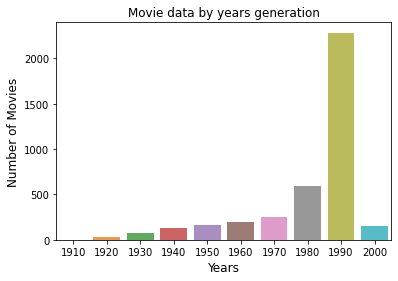

In [11]:
sns.barplot(moview_year_term.index, moview_year_term.values, alpha=0.8)
plt.title('Movie data by years generation')
plt.ylabel('Number of Movies', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.show()

### [장르의 속성 탐색]

In [12]:
# 가장 많이 사용된 장르의 조합을 출력
movie_data['genre'].value_counts()[:10]

Drama             843
Comedy            521
Horror            178
Comedy|Drama      162
Comedy|Romance    142
Drama|Romance     134
Documentary       116
Thriller          101
Action             65
Drama|Thriller     63
Name: genre, dtype: int64

In [13]:
# 가장 많이 등장한 장르의 속성을 추출
unique_genre_dict = {}
for index, row in movie_data.iterrows():

    # genre 피처를 '|' 구분자로 분리
    genre_combination = row['genre']
    parsed_genre = genre_combination.split('|')

    # 구분자로 분리한 장르의 속성을 unique_genre_dict에 각각 계산하여 저장
    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else :
            unique_genre_dict[genre] = 1
print(unique_genre_dict)

{'Animation': 105, "Children's": 251, 'Comedy': 1200, 'Adventure': 283, 'Fantasy': 68, 'Romance': 471, 'Drama': 1603, 'Action': 503, 'Crime': 211, 'Thriller': 492, 'Horror': 343, 'Sci-Fi': 276, 'Documentary': 127, 'War': 143, 'Musical': 114, 'Mystery': 106, 'Film-Noir': 44, 'Western': 68}


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


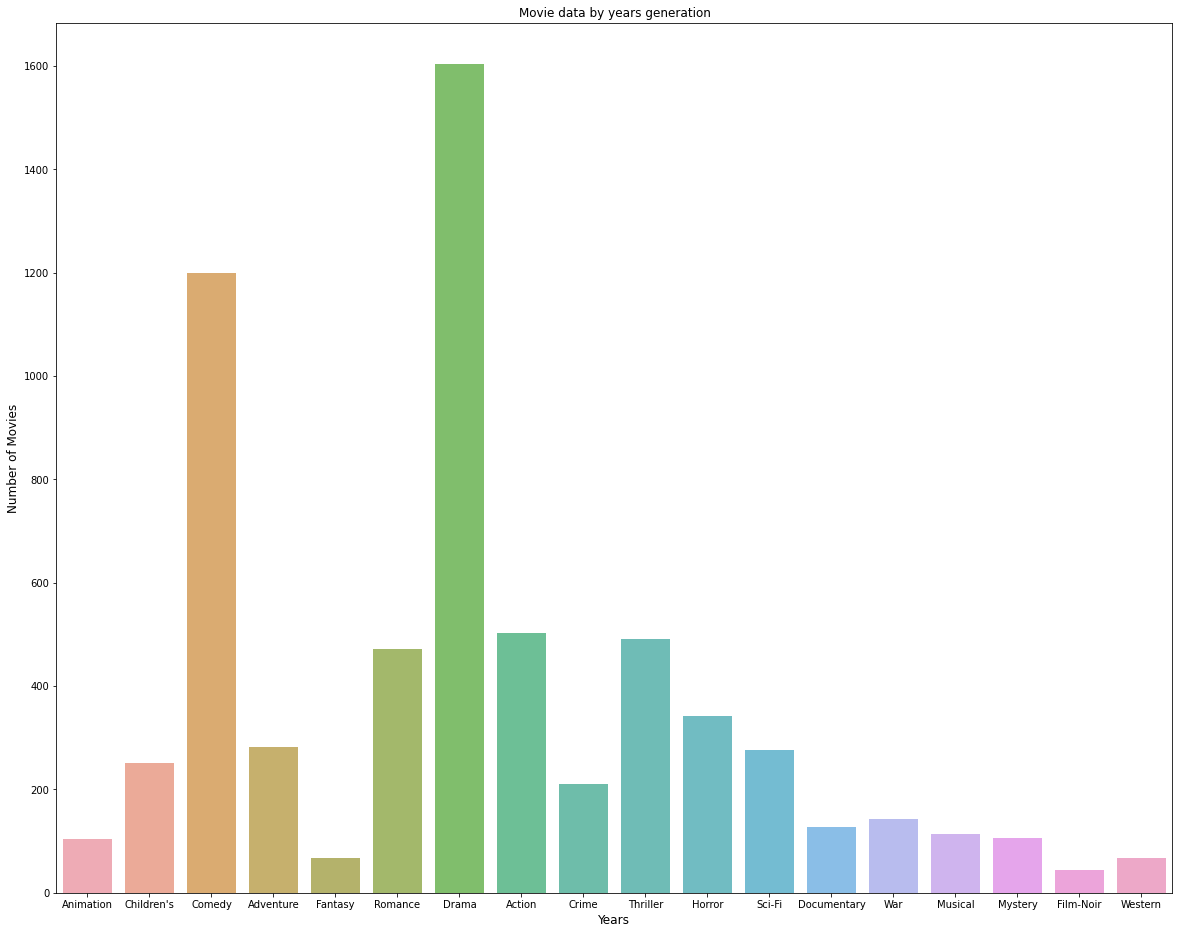

In [14]:
plt.rcParams['figure.figsize'] = [20, 16]
sns.barplot(list(unique_genre_dict.keys()), list(unique_genre_dict.values()), alpha=0.8)
plt.title('Movie data by years generation')
plt.ylabel('Number of Movies', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.show()

### [분석할 유저의 정보 탐색하기]

In [15]:
print('total number of user in data : ', len(user_data['user_id'].unique()))

total number of user in data :  6040


유저 데이터에 대한 탐색
*   유저의 성별 탐색
*   유저의 연령대 탐색

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


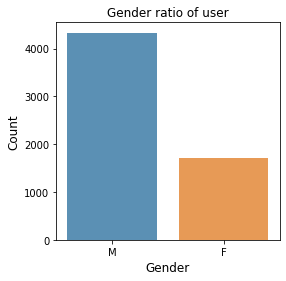

In [16]:
plt.rcParams['figure.figsize'] = [4,4]
user_gender = user_data['gender'].value_counts()
sns.barplot(user_gender.index, user_gender.values, alpha=0.8)
plt.title('Gender ratio of user')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

In [17]:
# 유저의 연령대 탐색
user_data['age'].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [18]:
def age_classification(age):
    if age == 1:
        return 'outlier'
    else :
        return str(age)[0] + "0"

user_data['ages'] = user_data['age'].apply(lambda x: age_classification(x))
user_ages = user_data['ages'].value_counts()

* 1: "18세 미만" 
* 18: "18-24" 
* 25: "25-34" 
* 35: "35-44" 
* 45: "45-49" 
* 50: "50-55" 
* 56: "56+"

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


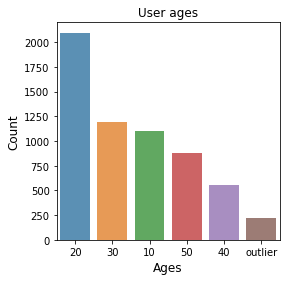

In [19]:
sns.barplot(user_ages.index, user_ages.values, alpha=0.8)
plt.title('User ages')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Ages', fontsize=12)
plt.show()

### [평점 데이터의 정보 탐색하기]

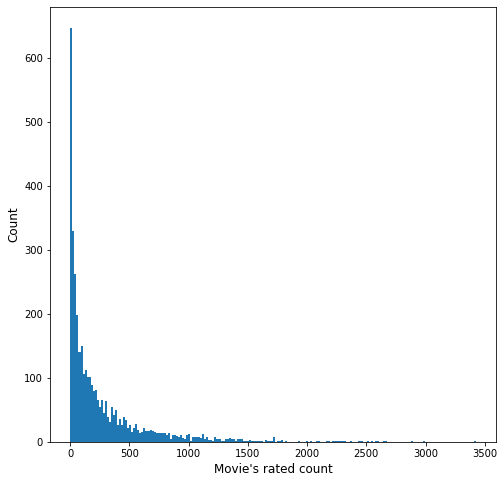

In [20]:
# 각 영화들이 평가받은 횟수를 탐색
movie_rate_count = rating_data.groupby('movie_id')['rating'].count().values
plt.rcParams['figure.figsize'] = [8, 8]
fig = plt.hist(movie_rate_count, bins=200)
plt.ylabel('Count', fontsize=12)
plt.xlabel("Movie's rated count", fontsize=12)
plt.show()

In [21]:
rating_data.groupby('movie_id')['rating'].count()

movie_id
1       2077
2        701
3        478
4        170
5        296
        ... 
3948     862
3949     304
3950      54
3951      40
3952     388
Name: rating, Length: 3706, dtype: int64

In [22]:
print('total number of movie in data : ', len(movie_data['movie_id'].unique()))
# 영화의 평점이 100개 미만인 것에 개수를 출력
print('total number of movie rated below 100 :', len(movie_rate_count[movie_rate_count < 100]))

total number of movie in data :  3883
total number of movie rated below 100 : 1687


In [23]:
# 영화별 평균 평점을 탐색
movie_grouped_rating_info = rating_data.groupby('movie_id')['rating'].agg(['count', 'mean'])
movie_grouped_rating_info.columns = ['rated_count', 'rating_mean']

In [24]:
movie_grouped_rating_info.head()

,rated_count,rating_mean
movie_id,,
1,2077,4.146846
2,701,3.201141
3,478,3.016736
4,170,2.729412
5,296,3.006757


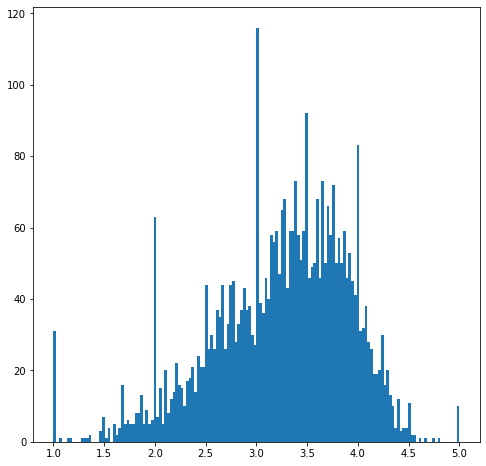

In [25]:
movie_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

In [26]:
# 100번 이상의 평가를 받은 영화 중, 평점이 높은 10개의 영화를 출력
merged_data = movie_grouped_rating_info.merge(movie_data, on=['movie_id'], how='left')
merged_data[merged_data['rated_count'] > 100][['rating_mean','title']].nlargest(10, 'rating_mean')

,rating_mean,title
1839,4.560510,Seven Samurai (The Magnificent Seven) (Shichin...
309,4.554558,"Shawshank Redemption, The (1994)"
802,4.524966,"Godfather, The (1972)"
708,4.520548,"Close Shave, A (1995)"
49,4.517106,"Usual Suspects, The (1995)"
513,4.510417,Schindler's List (1993)
1066,4.507937,"Wrong Trousers, The (1993)"
861,4.491489,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
1108,4.477725,Raiders of the Lost Ark (1981)
843,4.476190,Rear Window (1954)


유저 그룹 단위의 평점 속성을 분석하기
*   유저별로 평가한 영화의 개수
*   유저별로 평가한 평균 영화 점수
*   유저별로 평가한 영화 점수의 편차

In [27]:
# 유저별 영화 평가를 탐색
user_grouped_rating_info = rating_data.groupby('user_id')['rating'].agg(['count', 'mean', 'std'])
user_grouped_rating_info.columns = ['rated_count', 'rating_mean', 'rating_std']

In [28]:
user_grouped_rating_info.head()

,rated_count,rating_mean,rating_std
user_id,,,
1,53,4.188679,0.680967
2,129,3.713178,1.001513
3,51,3.901961,0.984985
4,21,4.190476,1.077917
5,198,3.146465,1.132699


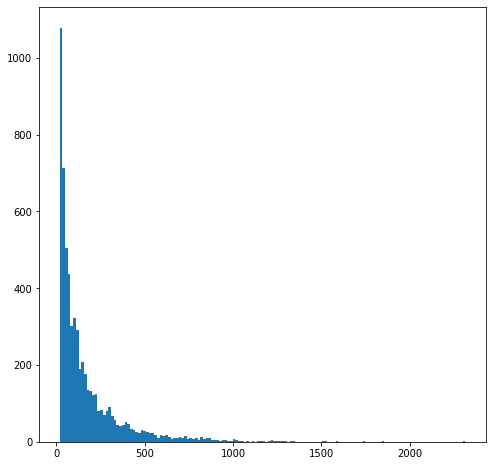

In [29]:
# 유저별로 평가한 영화 개수의 분포 출력
user_grouped_rating_info['rated_count'].hist(bins=150, grid=False)

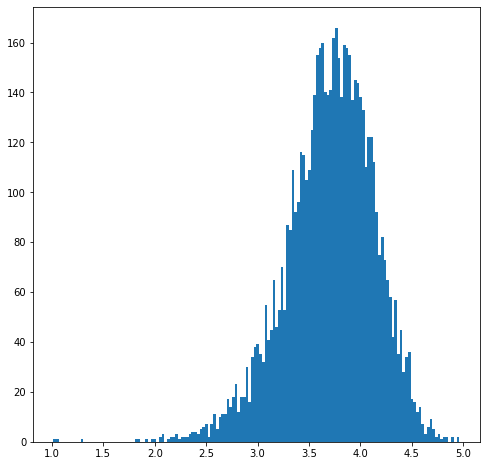

In [30]:
# 유저별로 평가한 영화 점수 평균의 분포 출력
user_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

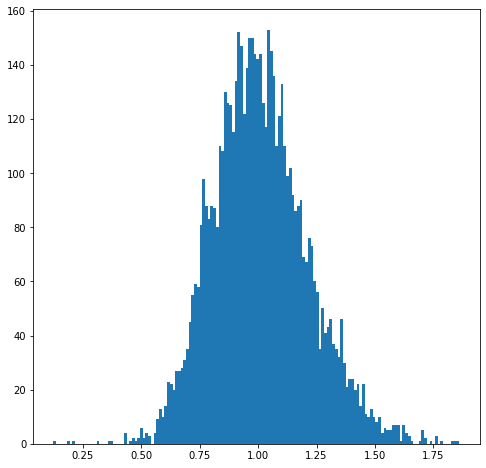

In [31]:
# 유저별로 평가한 영화 점수 편차의 분포 출력
user_grouped_rating_info['rating_std'].hist(bins=150, grid=False)

### [user-movie 형태의 테이블로 살펴보기]

In [32]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [33]:
# unstack() 함수로 user_id, movie_id를 축으로 하는 데이터를 생성합니다.
rating_table = rating_data[['user_id', 'movie_id', 'rating']].set_index(["user_id", "movie_id"]).unstack()
rating_table.head(10)

rating                                               ...            \
movie_id   1    2    3    4    5    6    7    8    9    10    ... 3943 3944   
user_id                                                       ...             
1           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
5           NaN  NaN  NaN  NaN  NaN  2.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6           4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
7           NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
8           4.0  NaN  NaN  3.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
9           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
10          5.0  5.0  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  ...  NaN  NaN   

                                                  
movie_id 3945 3946 3947 3948 3949 3950 3951 3952  
user_id                                           
1         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
9         NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  
10        NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  

[10 rows x 3706 columns]

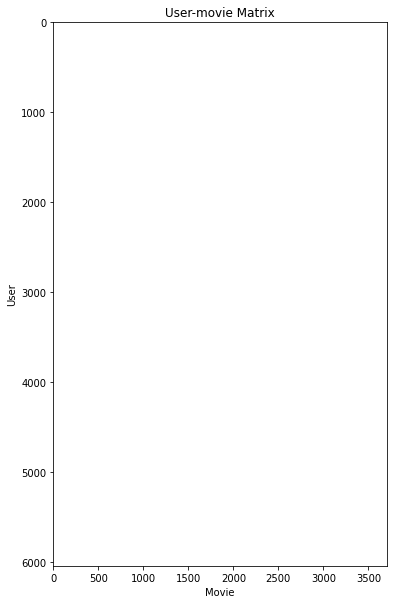

In [34]:
# user-movie 테이블을 시각화합니다.
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(rating_table)
plt.grid(False)
plt.xlabel("Movie")
plt.ylabel("User")
plt.title("User-movie Matrix")
plt.show()

## 수학적 기법을 활용한 평점 예측
### [SVD를 활용한 빈칸 채우기]

In [35]:
pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 20.9 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633739 sha256=63c305fff0b863d078f0e8246990fc4d9976e69e91d450406fb0e125b85b1b28
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [36]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

np.set_printoptions(suppress=True)

reader = Reader(rating_scale=(1, 5))

In [37]:
# 데이터 프레임을 생성합니다.
ratings_dict = {'item_id': [1,2,3,1,2,3,2],
                'user_id': ['a','a','a','b','b','b','c'],
                'rating': [2,4,4,2,5,4,5]}
df = pd.DataFrame(ratings_dict)
df.head(10)

,item_id,user_id,rating
0,1,a,2
1,2,a,4
2,3,a,4
3,1,b,2
4,2,b,5
5,3,b,4
6,2,c,5


In [38]:
# 데이터 프레임을 행렬로 변환하여 확인합니다.
df_matrix_table = df[['user_id', 'item_id', 'rating']].set_index(["user_id", "item_id"]).unstack().fillna(0)
df_matrix_table.head(10)

rating          
item_id      1    2    3
user_id                 
a          2.0  4.0  4.0
b          2.0  5.0  4.0
c          0.0  5.0  0.0

SVD를 이용한 빈칸 채우기 학습

In [39]:
data = Dataset.load_from_df(df=df[['user_id','item_id','rating']], reader=reader)
train_data = data.build_full_trainset()

In [40]:
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=10)
model.fit(train_data)

In [41]:
# 학습한 모델을 기반으로 빈공간의 점수를 예측합니다.

"""
build_anti_testset() : 

학습에 사용된 matrix에서 0으로 평가되어 있는(rating이 0인 지점) 부분의 데이터.
user 혹은 item은 학습에 반드시 등장한 적이 있어야 한다는 전제조건을 통해 추출.
"""

# test_data : 학습에 사용된 유저, 혹은 아이템이지만 점수는 매겨지지 않은 데이터입니다.
test_data = train_data.build_anti_testset()
predictions = model.test(test_data)

# 아래의 결과는 빈공간(test_data)의 점수를 예측한 결과입니다.
for _, iid, _, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "predicted rating :", predicted_rating)

Item id 1 | predicted rating : 3.618117750896707
Item id 3 | predicted rating : 3.8084197555335146


In [42]:
"""
build_testset() : 

학습에 사용된 matrix에서 0으로 평가되어 있는(rating이 0인 지점) 부분의 데이터.
user 혹은 item은 학습에 반드시 등장한 적이 있어야 한다는 전제조건을 통해 추출.
"""
test_data = train_data.build_testset()
predictions = model.test(test_data)

# 원래부터 비어있지 않았던 행렬의 값들을 출력한 것입니다. real rating은 원래 값, predicted rating은 행렬 완성 후 예측된 값입니다.
for _, iid, r_ui, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "real rating :", r_ui, "|", "predicted rating :", predicted_rating)

Item id 1 | real rating : 2.0 | predicted rating : 3.4760536809453604
Item id 2 | real rating : 4.0 | predicted rating : 3.790178496667191
Item id 3 | real rating : 4.0 | predicted rating : 3.7166348985520243
Item id 1 | real rating : 2.0 | predicted rating : 3.5388868192379315
Item id 2 | real rating : 5.0 | predicted rating : 3.869272430228554
Item id 3 | real rating : 4.0 | predicted rating : 3.7000508113371393
Item id 2 | real rating : 5.0 | predicted rating : 3.9073757268643683


### [아직 평가하지 않은 영화의 점수 예측하기]
*   MovieLens 데이터에 SVD 적용하기

In [43]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data = data.build_full_trainset()

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

training time of model: 91.45 seconds


영화의 점수를 예측할 타겟 유저 선정

In [44]:
# user_id 가 4인 유저의 영화 평가 데이터
target_user_id = 4
target_user_data = rating_data[rating_data['user_id']==target_user_id]
target_user_data.head()

,user_id,movie_id,rating,time
233,4,3468,5,978294008
234,4,1210,3,978293924
235,4,2951,4,978294282
236,4,1214,4,978294260
237,4,1036,4,978294282


In [45]:
# user_id 4인 유저가 평가한 영화 히스토리 정보를 추출
target_user_movie_rating_dict = {}

for index, row in target_user_data.iterrows():
    movie_id = row['movie_id']
    target_user_movie_rating_dict[movie_id] = row['rating']

print(target_user_movie_rating_dict)

{3468: 5, 1210: 3, 2951: 4, 1214: 4, 1036: 4, 260: 5, 2028: 5, 480: 4, 1196: 2, 1198: 5, 1954: 5, 1097: 4, 3418: 4, 3702: 4, 2366: 4, 1387: 5, 3527: 1, 1201: 5, 2692: 5, 2947: 5, 1240: 5}


타겟 유저가 보지 않은 영화 중, 예상 평점이 높은 10개 선정

In [46]:
# 타겟 유저가 보지 않은 영화 정보를 테스트 데이터로 생성
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    rating = 0
    if movie_id in target_user_movie_rating_dict:
        continue
    test_data.append((target_user_id, movie_id, rating))

In [47]:
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid not in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)

In [48]:
# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정합니다.
target_user_top10_predicted = sorted(target_user_movie_predict_dict.items(), 
                                     key=operator.itemgetter(1), reverse=True)[:10]

In [49]:
target_user_top10_predicted

[(17, 5),
 (58, 5),
 (213, 5),
 (246, 5),
 (262, 5),
 (309, 5),
 (527, 5),
 (608, 5),
 (615, 5),
 (668, 5)]

In [50]:
# title 정보를 출력하기 위해 movie_id 마다 movie_title을 딕셔너리 형태로 저장
movie_dict = {}
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    movie_title = row['title']
    movie_dict[movie_id] = movie_title

In [51]:
# 앞서 계산한 Top 10 영화에 movie_title을 매핑하여 출력
for predicted in target_user_top10_predicted:
    movie_id = predicted[0]
    predicted_rating = predicted[1]
    print(movie_dict[movie_id], ':', predicted_rating)

Sense and Sensibility (1995) : 5
Postino, Il (The Postman) (1994) : 5
Burnt By the Sun (Utomlyonnye solntsem) (1994) : 5
Hoop Dreams (1994) : 5
Little Princess, A (1995) : 5
Red Firecracker, Green Firecracker (1994) : 5
Schindler's List (1993) : 5
Fargo (1996) : 5
Bread and Chocolate (Pane e cioccolata) (1973) : 5
Pather Panchali (1955) : 5


In [52]:
# 타겟 유저의 기존 선호 영역과 비교
target_user_top10_real = sorted(target_user_movie_rating_dict.items(),
                                key=operator.itemgetter(1), reverse=True)[:10] # dict 두 번째에 있는 평점을 기준으로 정렬
for real in target_user_top10_real:
    movie_id = real[0]
    real_rating = real[1]
    print(movie_dict[movie_id],':', real_rating)

Hustler, The (1961) : 5
Star Wars: Episode IV - A New Hope (1977) : 5
Saving Private Ryan (1998) : 5
Raiders of the Lost Ark (1981) : 5
Rocky (1976) : 5
Jaws (1975) : 5
Good, The Bad and The Ugly, The (1966) : 5
Run Lola Run (Lola rennt) (1998) : 5
Goldfinger (1964) : 5
Terminator, The (1984) : 5


In [53]:
print(target_user_movie_rating_dict.items())
print('\n')
print(target_user_movie_rating_dict.keys())
print('\n')
print(target_user_movie_rating_dict.values())

dict_items([(3468, 5), (1210, 3), (2951, 4), (1214, 4), (1036, 4), (260, 5), (2028, 5), (480, 4), (1196, 2), (1198, 5), (1954, 5), (1097, 4), (3418, 4), (3702, 4), (2366, 4), (1387, 5), (3527, 1), (1201, 5), (2692, 5), (2947, 5), (1240, 5)])


dict_keys([3468, 1210, 2951, 1214, 1036, 260, 2028, 480, 1196, 1198, 1954, 1097, 3418, 3702, 2366, 1387, 3527, 1201, 2692, 2947, 1240])


dict_values([5, 3, 4, 4, 4, 5, 5, 4, 2, 5, 5, 4, 4, 4, 4, 5, 1, 5, 5, 5, 5])


## 예측 모델 평가하기
### [예측 모델의 평가 방법]
RMSE 계산

In [54]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다. 학습 데이터와 테스트 데이터를 8:2로 분할합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

predictions = model.test(test_data)

# 테스트 데이터의 RMSE를 출력합니다.
print("RMSE of test dataset in SVD model:")
accuracy.rmse(predictions)

training time of model: 119.61 seconds
RMSE of test dataset in SVD model:
RMSE: 0.8602


0.860221215511736

하이퍼 파라미터 튜닝

In [55]:
rmse_list_by_factors = []
ttime_list_by_factors = []
for n in range(6, 15):    
    train_start = time.time()
    model = SVD(n_factors=n,
                lr_all=0.005,
                reg_all=0.02,
                n_epochs=100)
    model.fit(train_data)
    train_end = time.time()
    print("training time of model: %.2f seconds" % (train_end - train_start))
    print("RMSE of test dataset in SVD model, n_factors=" + str(n))
    predictions = model.test(test_data)
    rmse_result = accuracy.rmse(predictions)
    rmse_list_by_factors.append(rmse_result)
    ttime_list_by_factors.append((train_end - train_start))
    print("------------------------------------")
print("searching n_factors is finish.")

training time of model: 90.74 seconds
RMSE of test dataset in SVD model, n_factors=6
RMSE: 0.8609
------------------------------------
training time of model: 90.95 seconds
RMSE of test dataset in SVD model, n_factors=7
RMSE: 0.8607
------------------------------------
training time of model: 92.91 seconds
RMSE of test dataset in SVD model, n_factors=8
RMSE: 0.8627
------------------------------------
training time of model: 97.70 seconds
RMSE of test dataset in SVD model, n_factors=9
RMSE: 0.8611
------------------------------------
training time of model: 98.69 seconds
RMSE of test dataset in SVD model, n_factors=10
RMSE: 0.8639
------------------------------------
training time of model: 112.00 seconds
RMSE of test dataset in SVD model, n_factors=11
RMSE: 0.8652
------------------------------------
training time of model: 104.71 seconds
RMSE of test dataset in SVD model, n_factors=12
RMSE: 0.8672
------------------------------------
training time of model: 105.47 seconds
RMSE of tes

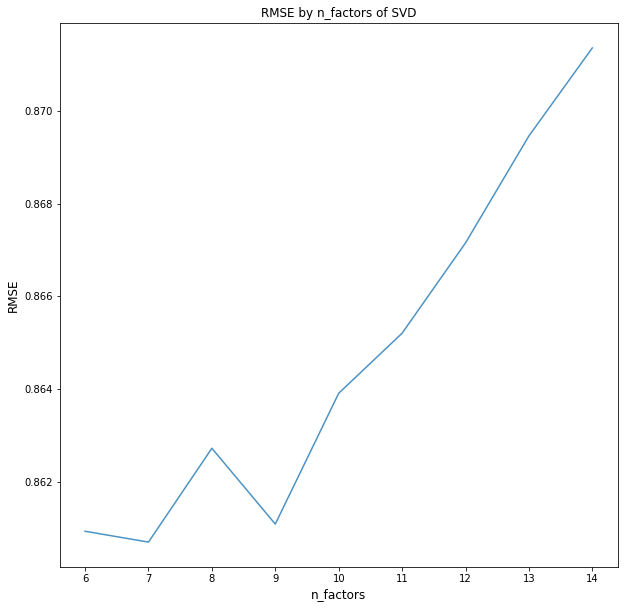

In [57]:
plt.plot(range(6, 15), rmse_list_by_factors, alpha=0.8)
plt.title('RMSE by n_factors of SVD')
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

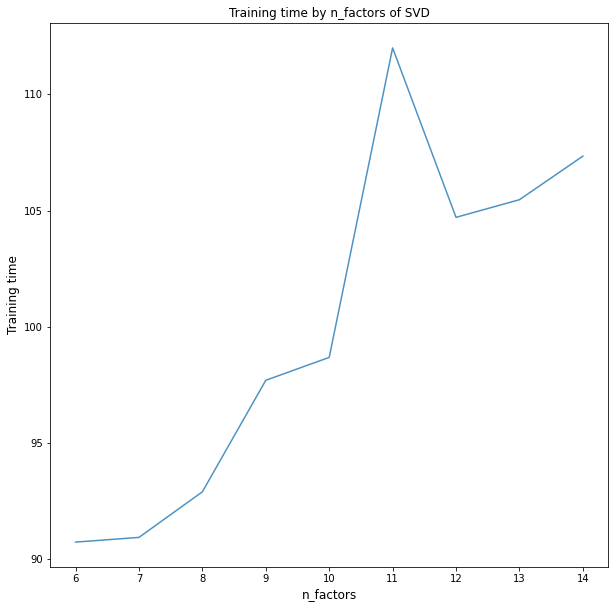

In [58]:
plt.plot(range(6, 15), ttime_list_by_factors, alpha=0.8)
plt.title('Training time by n_factors of SVD')
plt.ylabel('Training time', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

### [실제 평점과의 비교 시각화]
평점 예측 단계

In [59]:
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    if movie_id in target_user_movie_rating_dict:
        rating = target_user_movie_rating_dict[movie_id]
        test_data.append((target_user_id, movie_id, rating))

In [60]:
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정합니다.
target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)

In [61]:
target_user_movie_predict_dict

{260: 4.127607602996396,
 480: 3.4429700904241836,
 1036: 3.8344807164920507,
 1097: 3.947859649640946,
 1196: 3.8143127673176314,
 1198: 4.408784263948442,
 1201: 4.394474996295938,
 1210: 3.453158222212476,
 1214: 4.130994673681297,
 1240: 4.062204510084989,
 1387: 4.161658097847147,
 1954: 4.172732064364875,
 2028: 4.717830906376559,
 2366: 3.9440267555724677,
 2692: 4.041981767249976,
 2947: 4.296349018347654,
 2951: 4.361620707674217,
 3418: 4.131920281055115,
 3468: 4.740326669755241,
 3527: 3.1156245888096903,
 3702: 3.999780215739851}

In [62]:
# 예측 점수와 실제 점수를 영화 타이틀에 매핑합니다.
origin_rating_list = []
predicted_rating_list = []
movie_title_list = []
idx = 0
for movie_id, predicted_rating in target_user_movie_predict_dict.items():
    idx = idx + 1
    predicted_rating = round(predicted_rating, 2)
    origin_rating = target_user_movie_rating_dict[movie_id]
    movie_title = movie_dict[movie_id]
    print("movie", str(idx), ":", movie_title, "-", origin_rating, "/", predicted_rating)
    origin_rating_list.append(origin_rating)
    predicted_rating_list.append(predicted_rating)
    movie_title_list.append(str(idx))

movie 1 : Star Wars: Episode IV - A New Hope (1977) - 5 / 4.13
movie 2 : Jurassic Park (1993) - 4 / 3.44
movie 3 : Die Hard (1988) - 4 / 3.83
movie 4 : E.T. the Extra-Terrestrial (1982) - 4 / 3.95
movie 5 : Star Wars: Episode V - The Empire Strikes Back (1980) - 2 / 3.81
movie 6 : Raiders of the Lost Ark (1981) - 5 / 4.41
movie 7 : Good, The Bad and The Ugly, The (1966) - 5 / 4.39
movie 8 : Star Wars: Episode VI - Return of the Jedi (1983) - 3 / 3.45
movie 9 : Alien (1979) - 4 / 4.13
movie 10 : Terminator, The (1984) - 5 / 4.06
movie 11 : Jaws (1975) - 5 / 4.16
movie 12 : Rocky (1976) - 5 / 4.17
movie 13 : Saving Private Ryan (1998) - 5 / 4.72
movie 14 : King Kong (1933) - 4 / 3.94
movie 15 : Run Lola Run (Lola rennt) (1998) - 5 / 4.04
movie 16 : Goldfinger (1964) - 5 / 4.3
movie 17 : Fistful of Dollars, A (1964) - 4 / 4.36
movie 18 : Thelma & Louise (1991) - 4 / 4.13
movie 19 : Hustler, The (1961) - 5 / 4.74
movie 20 : Predator (1987) - 1 / 3.12
movie 21 : Mad Max (1979) - 4 / 4.0


결과의 시각화

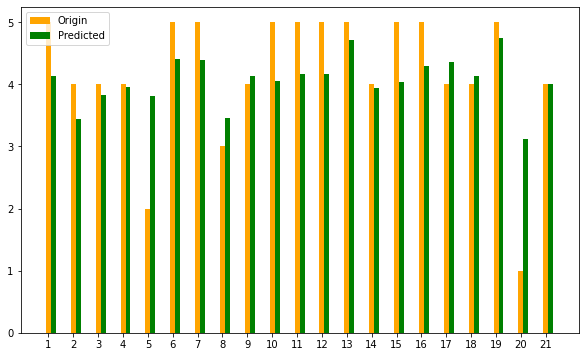

In [63]:
# 실제 점수와 예측 점수를 리스트로 추출합니다.
origin = origin_rating_list
predicted = predicted_rating_list
 
# 영화의 개수만큼 bar 그래프의 index 개수를 생성합니다.
plt.rcParams['figure.figsize'] = (10,6)
index = np.arange(len(movie_title_list))
bar_width = 0.2
 
# 실제 점수와 예측 점수를 bar 그래프로 출력합니다.
rects1 = plt.bar(index, origin, bar_width,
                 color='orange',
                 label='Origin')
rects2 = plt.bar(index + bar_width, predicted, bar_width,
                 color='green',
                 label='Predicted')
plt.xticks(index, movie_title_list)
plt.legend()
plt.show()

### [20대가 좋아할만한 영화 예측하기]

In [64]:
user_age_20_list = user_data[user_data['ages']=="20"]['user_id'].tolist()

In [65]:
# 평가하지 않은 user-movie rating들에 대한 예측값을 계산합니다.
preprocess_start = time.time()
test_data = train_data.build_anti_testset()
predictions = model.test(test_data)

# 평가하지 않은 user-movie rating 중에서, 20대의 예측값을 선별합니다.
hidden_user_age_20_movie_predict_dict = {}
for uid, mid, _, predicted_rating, _ in predictions:
    if uid in user_age_20_list:
        if mid in hidden_user_age_20_movie_predict_dict:
            hidden_user_age_20_movie_predict_dict[mid]['sum'] += predicted_rating
            hidden_user_age_20_movie_predict_dict[mid]['count'] += 1
        else:
            hidden_user_age_20_movie_predict_dict[mid] = {}
            hidden_user_age_20_movie_predict_dict[mid]['sum'] = predicted_rating
            hidden_user_age_20_movie_predict_dict[mid]['count'] = 1

# 영화마다 20대 유저의 rating 평균값을 계산합니다.
for movie_id, score_dict in hidden_user_age_20_movie_predict_dict.items():
    score_dict['mean'] = score_dict['sum'] / score_dict['count']
    
# Top 10 movie_id를 추출합니다.
hidden_user_age_20_movie_list = sorted(hidden_user_age_20_movie_predict_dict, 
                                       key=lambda x: (hidden_user_age_20_movie_predict_dict[x]['mean']), 
                                       reverse=True)[:10]

preprocess_end = time.time()
print("preprocess time: %.2f seconds" % (preprocess_end - preprocess_start))

preprocess time: 782.16 seconds


In [66]:
# 선정된 리스트를 출력합니다.
print("20대가 좋아할지도 모르는 영화 Top 10")
print("---------------------------------")
for movie_id in hidden_user_age_20_movie_list:
    movie_title = movie_dict[movie_id]
    age_20_rating = hidden_user_age_20_movie_predict_dict[movie_id]['mean']
    print("title:", movie_title, "| rating:", age_20_rating)

20대가 좋아할지도 모르는 영화 Top 10
---------------------------------
title: Sanjuro (1962) | rating: 4.587147783592303
title: Shawshank Redemption, The (1994) | rating: 4.546086982706323
title: Usual Suspects, The (1995) | rating: 4.486702201343016
title: Lamerica (1994) | rating: 4.473085068161943
title: For All Mankind (1989) | rating: 4.467047436841585
title: Apple, The (Sib) (1998) | rating: 4.455768815137835
title: Schindler's List (1993) | rating: 4.442531371983872
title: Song of Freedom (1936) | rating: 4.409576539978849
title: Rear Window (1954) | rating: 4.4079480917485085
title: I Am Cuba (Soy Cuba/Ya Kuba) (1964) | rating: 4.37779462428329
